## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:Шахвалиева Юлиана Сергеевна

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import math
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов (1 балл)

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [13]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [14]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

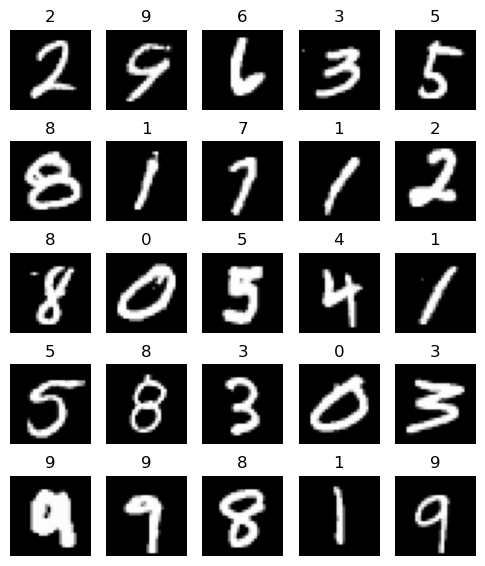

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [244]:
def init_layer(layer, mean=0, std=0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [243]:
class Linear(nn.Module):
    def __init__(self, init_func):
        super().__init__()
        self.init_func = init_func
        self.layers = nn.Sequential(*self.get_layers())

    def get_layers(self):
        layers = [self.customize_layer(nn.Linear(784, 500)), nn.Tanh()]

        for i in range(10):
            layers.append(self.customize_layer(nn.Linear(500, 500)))
            layers.append(nn.Tanh())

        layers.append(self.customize_layer(nn.Linear(500, 10)))

        return layers

    def customize_layer(self, layer):
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)  
        self.init_func(layer)
        return layer

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [245]:
network = nn.Sequential(layer)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0284836292266846
backward 0.03711842745542526


In [246]:
linear_network = Linear(init_layer)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = linear_network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(linear_network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0284836292266846
forward 0.8533836603164673
forward 0.7841501832008362
forward 0.7707303166389465
forward 0.7682072520256042
forward 0.7641487121582031
forward 0.7665584683418274
forward 0.7636125087738037
forward 0.7633937001228333
forward 0.7654189467430115
forward 0.764834463596344
forward 0.7653458714485168
backward 0.03711842745542526
backward 0.014412982389330864
backward 0.014246356673538685
backward 0.014104126021265984
backward 0.014694551937282085
backward 0.015598115511238575
backward 0.01658295840024948
backward 0.01780068501830101
backward 0.021778609603643417
backward 0.02577345259487629
backward 0.02922893688082695
backward 0.026976877823472023


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [247]:
def init_layer_xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    const = math.sqrt(6) / math.sqrt(layer.in_features + layer.out_features)
    bias.uniform_(-const, const)
    weight.uniform_(-const, const)

In [248]:
linear_network_xavier = Linear(init_layer_xavier)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = linear_network_xavier(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(linear_network_xavier.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0284836292266846
forward 0.6584579944610596
forward 0.49978014826774597
forward 0.420110285282135
forward 0.36406391859054565
forward 0.32810908555984497
forward 0.302589476108551
forward 0.2797776460647583
forward 0.2620968818664551
forward 0.2506248354911804
forward 0.2439650297164917
forward 0.23069193959236145
backward 0.03711842745542526
backward 0.019851896911859512
backward 0.01806061901152134
backward 0.017320139333605766
backward 0.016529157757759094
backward 0.01475050114095211
backward 0.013279175385832787
backward 0.011268172413110733
backward 0.009183309972286224
backward 0.007659550756216049
backward 0.006025555543601513
backward 0.0035415804013609886


In [266]:
def init_layer_he(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    const = 2 / layer.out_features
    bias.normal_(0, const)
    weight.normal_(0, const)

In [267]:
linear_network_he = Linear(init_layer_he)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = linear_network_he(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(linear_network_he.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0284836292266846
forward 0.11150749027729034
forward 0.010507653467357159
forward 0.004036118276417255
forward 0.0038882619701325893
forward 0.0038331043906509876
forward 0.003972483333200216
forward 0.003924296237528324
forward 0.003995204344391823
forward 0.004005259368568659
forward 0.004004792310297489
forward 0.00389186036773026
backward 0.03711842745542526
backward 0.06818775832653046
backward 0.006100896280258894
backward 0.0005342015065252781
backward 4.891681237495504e-05
backward 4.236615950503619e-06
backward 3.754111048692721e-07
backward 3.4264640902392784e-08
backward 3.102533341348135e-09
backward 2.8402044605080334e-10
backward 2.5507726139628595e-11
backward 2.1935096967962142e-12


In [272]:
def init_layer_he_1(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    const = 2 / math.sqrt(layer.out_features)
    bias.normal_(0, const)
    weight.normal_(0, const)

In [273]:
linear_network_he_1 = Linear(init_layer_he_1)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = linear_network_he_1(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(linear_network_he_1.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0284836292266846
forward 0.8377900719642639
forward 0.7629113793373108
forward 0.7394015192985535
forward 0.732191264629364
forward 0.7270113825798035
forward 0.7277253270149231
forward 0.7299947142601013
forward 0.7291190028190613
forward 0.7288584113121033
forward 0.7291982769966125
forward 0.7278624773025513
backward 0.03711842745542526
backward 0.09954558312892914
backward 0.09725890308618546
backward 0.09449392557144165
backward 0.09506769478321075
backward 0.09921660274267197
backward 0.10710950195789337
backward 0.10654965043067932
backward 0.11519457399845123
backward 0.1289759874343872
backward 0.14232531189918518
backward 0.1248442679643631


<i> 1.4 Сделайте выводы по первой части </i>

Были протестированы 3 способа начальной инициализации весов нейронной сети: инициализация случайным шумом из нормального распределения, инициализация Xavier и He. Первые два способа показали при обучении примерно равную дисперсию активации градиентов как при прямом проходе, так и при обратном. Возникли трудности с инициализацией He, так как в случае использования формулы из лекции $W_i = N(0, \frac{2}{n_i})$ наблюдалось затухание градиента. Это может быть связано либо с тем, что этот метод предназначен для использования с нейросетями, у которых `ReLU()` в качестве функции активации, а не `Tanh()` как у нас. Также это может быть связано с самой архитектурой сети: $\frac{2}{784}= 0,0025$. Это очень маленькое число для дисперсии, это могло привести к тому, что веса инициализировались нулями. Для решения этой проблемы было принято решение об иницализации весов следующим образом: $W_i = N(0, \frac{2}{\sqrt{n_i}})$, это увеличит дисперсию, а значит числа будут более отличны от нуля. Предположение сработало, при такой инициализации не наблюдается затухание градиента.

### Часть 2: Dropout (1 балл)

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [163]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        if self.training:
            mask = Variable(torch.ones_like(self.linear.weight).bernoulli_(self.p), requires_grad=False)

        else:
            mask = Variable(torch.ones_like(self.linear.weight), requires_grad=False)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [188]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Epoch 9... (Train/Test) NLL: 0.429/0.110	Accuracy: 0.828/0.967


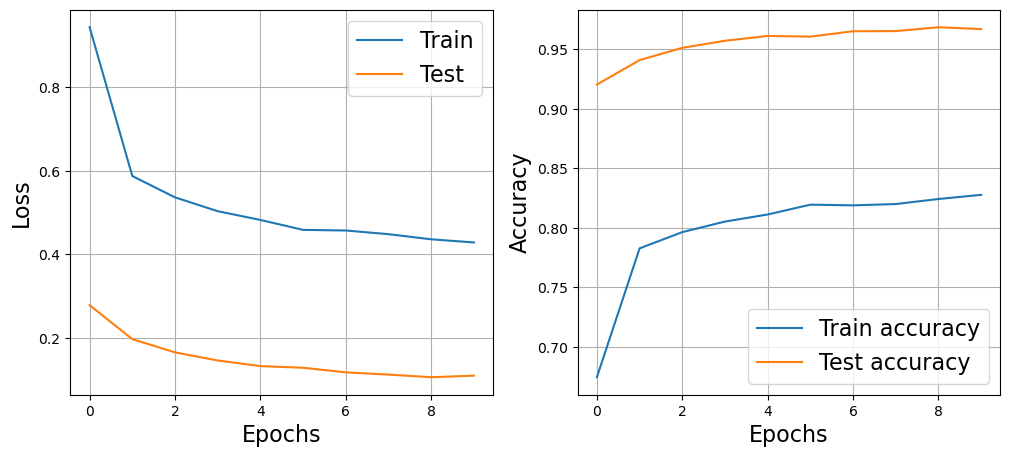

([0.9441485782421982,
  0.5878310994679994,
  0.5366620573280717,
  0.5035589989314455,
  0.4826042723299852,
  0.458803890674099,
  0.45736242875234406,
  0.4485339790519112,
  0.4362524787246037,
  0.4286633476074825],
 [0.27843199198759055,
  0.19713806785360166,
  0.16543419017821928,
  0.1460265959082525,
  0.1325810575692714,
  0.1286077113657058,
  0.11756546366252477,
  0.1122906543314457,
  0.10595811882256707,
  0.10970622395412831],
 [0.6746902,
  0.7828603,
  0.7964697,
  0.80533165,
  0.81127846,
  0.81952405,
  0.81894654,
  0.82004595,
  0.82427704,
  0.827753],
 [0.92029274,
  0.94086236,
  0.95114714,
  0.9570807,
  0.96113527,
  0.9605419,
  0.965091,
  0.9651899,
  0.96845335,
  0.966871])

In [262]:
from train_utils import train

layers = [nn.Dropout(p=0.2), nn.Linear(196, 10), nn.Dropout(p=0.2)]

network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.795/0.457	Accuracy: 0.737/0.928


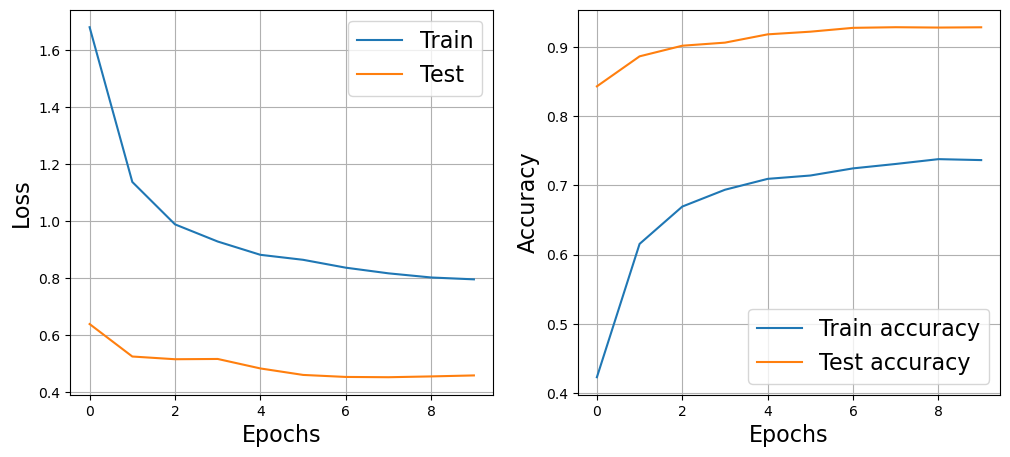

([1.6817434819014088,
  1.1376828561459522,
  0.988547239857696,
  0.9282627977542023,
  0.8814904123608237,
  0.863986221712027,
  0.8362551039215852,
  0.8163906844185868,
  0.8018157238772174,
  0.7952406827066498],
 [0.638135846657089,
  0.5239488063733789,
  0.5144022280656839,
  0.5153299849244612,
  0.48196888432095325,
  0.4592053224391575,
  0.4521328330841623,
  0.4511441909531249,
  0.4539744744572458,
  0.4574586118135271],
 [0.42316318,
  0.6156217,
  0.66952074,
  0.6938022,
  0.70951045,
  0.7143357,
  0.72464687,
  0.7310212,
  0.73796195,
  0.736596],
 [0.84305775,
  0.8863726,
  0.901701,
  0.9061511,
  0.9181171,
  0.9219739,
  0.9275119,
  0.9284019,
  0.9279074,
  0.928303])

In [263]:
layers = [DropConnect(196, 10, 0.2)]

network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по второй части. </i>

При "выключении" каких-то частей нейронной сети наблюдается следующий эффект: на тестовой выборке нейросеть показывает себя лучше (меньше ошибка, выше точность), чем на обучающей выборке. Это связано с тем, что при обучении используется не вся архитектура, а при предсказании на тестовой выборке - вся. Оба метода показали высокое качество классификации на тестовой выборке: Dropout - 96,7%, DropConnect - 92,8%. 

### Часть 3: Batch Normalization (3 балла)

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [177]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - torch.mean(x, dim=1, keepdim=True)) / torch.std(x, dim=1, keepdim=True)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.577/0.543	Accuracy: 0.952/0.961


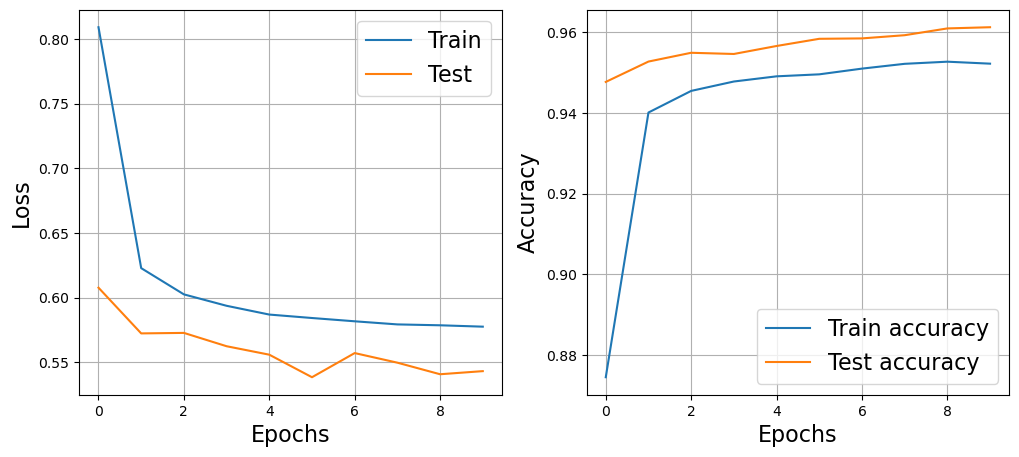

([0.8089954465437037,
  0.6227263238892626,
  0.6024354569185009,
  0.593610643196716,
  0.5868288377708972,
  0.5841643639337788,
  0.5816240328461376,
  0.5792173918630523,
  0.5785356707918619,
  0.5774734599758059],
 [0.6076144538348234,
  0.5722661425795736,
  0.5726516318472126,
  0.562345928029169,
  0.5558025885986376,
  0.5383820345130148,
  0.5570520139947722,
  0.5496269558803945,
  0.5406818850130974,
  0.5430849413328533],
 [0.8745502,
  0.9401097,
  0.9454624,
  0.94778895,
  0.94907165,
  0.94956577,
  0.9509817,
  0.95216995,
  0.95269746,
  0.9522088],
 [0.9476859,
  0.9527294,
  0.9549051,
  0.9546084,
  0.95658624,
  0.9583663,
  0.9584652,
  0.95925635,
  0.9609375,
  0.96123415])

In [264]:
layers = [nn.BatchNorm1d(196, affine=False), nn.Linear(196, 10), nn.BatchNorm1d(10, affine=False)]

network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.542/0.537	Accuracy: 0.957/0.959


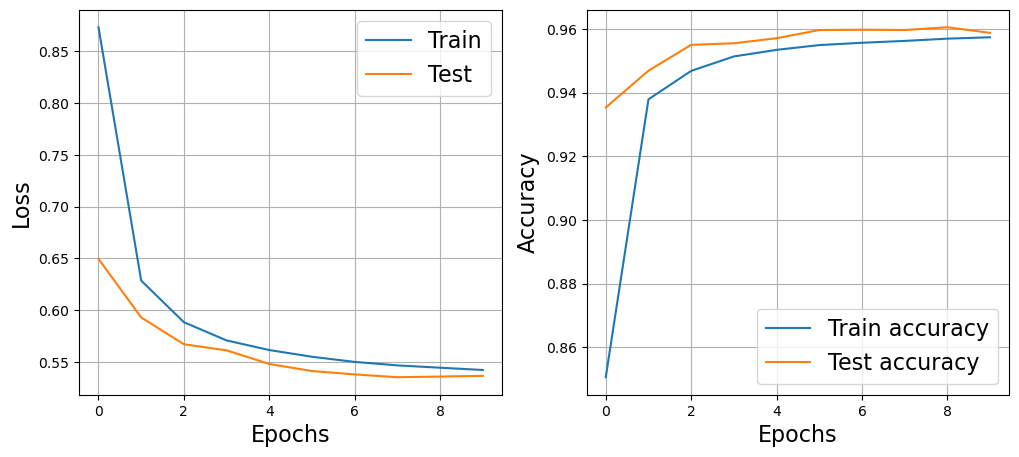

([0.8731408513176924,
  0.6286439445735549,
  0.5884559293037285,
  0.5708667630198668,
  0.5615868650392682,
  0.5551222239984378,
  0.5501434325155165,
  0.5467841160704078,
  0.5445399793353416,
  0.5423474766171055],
 [0.6496113651915442,
  0.5930573661116105,
  0.5671753000609482,
  0.561320642504511,
  0.5481374418433709,
  0.5413480710379684,
  0.5380717991273615,
  0.5353681286679038,
  0.5359896908078012,
  0.5366930256161508],
 [0.8506352,
  0.93789977,
  0.9468228,
  0.9513648,
  0.95343035,
  0.9549352,
  0.955657,
  0.95624554,
  0.9569508,
  0.9573839],
 [0.9353244,
  0.94689476,
  0.955004,
  0.9554984,
  0.9570807,
  0.9596519,
  0.9597508,
  0.9596519,
  0.9605419,
  0.9587619])

In [265]:
layers = [LayerNormalization(), nn.Linear(196, 10), LayerNormalization()]

network = TestNetwork(nn.Sequential(*layers))
train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

Нормализация показала себя иначе, чем "выключение" нейронов. В случае нормализации нет того эффекта, когда тестовая выборка показывает себя значительно лучше, чем тренировочная. Сравнивая нормализации между собой, можно сделать вывод о том, что `Layer normalization` показала себя лучше, чем `Batch Normalization`. Скорее всего это связано с тем, что первая использует более "персонализированную" информацию, то есть нормировка идет независимо по каждому нейрону. Тем не менее, разница не сильно большая: всего 1% точности.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: